In [1]:
import numpy as np
import torch
import sys
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import pandas as pd

from torch.utils.data import DataLoader, Dataset, TensorDataset
import warnings 
warnings.filterwarnings("ignore")
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
os.chdir("/home/luqiaolin/projects/Benchmarking_paper_code/cosmx_spot_data/pretrain/kidney/CosMx_kidney")


/home/luqiaolin/anaconda3/envs/baseline_code/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!ls
!pwd

annot.csv	 Run1080_SP19_1139   Run1081_SP17_2566	Run1087_SP19_4061
customlocs.csv	 Run1080_SP20_10838  Run1081_SP18_3323	Run1087_SP20_1098
Kidney_2566.pdf  Run1080_SP20_642    Run1087_SP17_8693	um.csv
raw.RDS		 Run1080_SP21_213    Run1087_SP18_8471


/home/luqiaolin/projects/Benchmarking_paper_code/cosmx_spot_data/pretrain/kidney/CosMx_kidney


### standard: fov in metadata_file, not Run1080_SP20_642_fov_positions_file


In [3]:
gene_spatial = pd.read_csv('./Run1080_SP20_642/Run1080_SP20_642_tx_file.csv')
gene_expression = pd.read_csv('./Run1080_SP20_642/Run1080_SP20_642_exprMat_file.csv')
cell_boundary = pd.read_csv('./Run1080_SP20_642/Run1080_SP20_642_metadata_file.csv')
fov_position = pd.read_csv('./Run1080_SP20_642/Run1080_SP20_642_fov_positions_file.csv')
CosMx_cell_type = pd.read_csv('./annot.csv')

In [4]:
print(min(gene_spatial["x_global_px"]), max(gene_spatial["x_global_px"]))
print(min(gene_spatial["y_global_px"]), max(gene_spatial["y_global_px"]))
print(min(gene_spatial["x_local_px"]), max(gene_spatial["x_local_px"]))
print(min(gene_spatial["y_local_px"]), max(gene_spatial["y_local_px"]))

12926.3166666667 63909.0922222222
-176083.774444444 -119626.586111111
9.65 5461.3
10.3000000000002 3635.075


In [5]:
gene_expression.shape

(14324, 981)

In [6]:
min(cell_boundary["CenterX_global_px"]), max(cell_boundary["CenterX_global_px"])
min(cell_boundary["CenterY_global_px"]), max(cell_boundary["CenterY_global_px"])

(-176075.444444444, -119627.111111111)

In [7]:
x_coordinate = [x / 10000 for x in list(fov_position["x_global_px"])]
y_coordinate = [y / 10000 for y in list(fov_position["y_global_px"])]

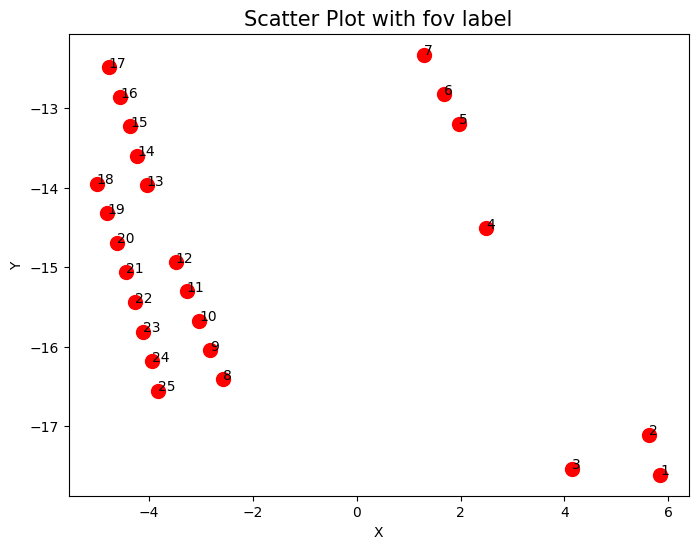

In [8]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(20)

X=np.random.randint(10, size=(5))
Y=np.random.randint(10, size=(5))

X = x_coordinate
Y = y_coordinate

annotations = list(fov_position["fov"])

plt.figure(figsize=(8,6))
plt.scatter(X,Y,s=100,color="red")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Scatter Plot with fov label",fontsize=15)
for i, label in enumerate(annotations):
    plt.annotate(label, (X[i], Y[i]))

plt.show()

In [9]:
def get_spot_x_y_range(x_global_px, y_global_px, fov_id, fov_spot_coordinates):
    fov_length = 5472
    fov_width = 3648
    x_l = x_global_px
    y_l = y_global_px
    x_h = x_l + fov_length
    y_h = y_l + fov_width
    
    for i in range(1, 6):  # 5
        for j in range(1, 5):  # 4
            spot_id = (i - 1) * 4 + j
            x = x_l + (5472 / 10.0) * 1 + (5472 / 5.0) * (i - 1)
            y = y_h - (3648 / 8.0) * 1 - (3648 / 4.0) * (j - 1)
            fov_spot_coordinates = fov_spot_coordinates.append(
                {'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y},
                ignore_index=True
            )

    fov_spot_coordinates['x'] = fov_spot_coordinates['x'] * 0.18 * 1e-4
    fov_spot_coordinates['y'] = fov_spot_coordinates['y'] * 0.18 * 1e-4

    return fov_spot_coordinates


In [10]:
fov_spot_coordinates = pd.DataFrame(columns = ['fov', 'spot_id', 'x', 'y'])
coordinates = get_spot_x_y_range(0, 0, 8, fov_spot_coordinates)

# Benchmark Generation

In [11]:
"""
1 μm(micrometer) = 1e-4 cm
GeoMx: spot region area
1. mean: 37456.28 μm2
2. median: 24168.74 μm2

CosMx lung & kidney: 
1. All FOVs are the same dimension, 5472 x 3648 pixels
2. multiply the pixel value by 0.18 um per pixel
3. FOV area: 5472 x 3648 pixels -> 984.96um x 656.64um = 646,764.134 um2 

New Benchamrk from CosMx
1. length: 5472 pixels, width: 3648 pixels
2. simulated spot: 
    length: 5472 pixels / 5 = 1094.4 pixel = 196.992 um
    width: 3648 pixels / 4 = 912 pixel = 164.16 um
    one spot area: 49.248 um * 65.664 um = 3237.6 um2
3. In total: 20 spots / FOV

spot_fov_cellId_mapping.csv (spot_id, fov, cell_Id)
spot_gene_expression.csv (spot_id, gene1, gene2, gene3...)

"""

'\n1 μm(micrometer) = 1e-4 cm\nGeoMx: spot region area\n1. mean: 37456.28 μm2\n2. median: 24168.74 μm2\n\nCosMx lung & kidney: \n1. All FOVs are the same dimension, 5472 x 3648 pixels\n2. multiply the pixel value by 0.18 um per pixel\n3. FOV area: 5472 x 3648 pixels -> 984.96um x 656.64um = 646,764.134 um2 \n\nNew Benchamrk from CosMx\n1. length: 5472 pixels, width: 3648 pixels\n2. simulated spot: \n    length: 5472 pixels / 5 = 1094.4 pixel = 196.992 um\n    width: 3648 pixels / 4 = 912 pixel = 164.16 um\n    one spot area: 49.248 um * 65.664 um = 3237.6 um2\n3. In total: 20 spots / FOV\n\nspot_fov_cellId_mapping.csv (spot_id, fov, cell_Id)\nspot_gene_expression.csv (spot_id, gene1, gene2, gene3...)\n\n'

## 1. spot_fov_cellId_mapping.csv

In [12]:
def get_spot_fov_cellId_mapping(data_result, cell_boundary_fov_11):
    new_col_val = cell_boundary_fov_11.shape[0]* [0]
    cell_boundary_fov_11.insert(loc=0, column='spot_id', value=new_col_val)

    for i in range(cell_boundary_fov_11.shape[0]):
        one_row_sample = cell_boundary_fov_11.iloc[i]

        center_x = one_row_sample["CenterX_local_px"]
        center_y = one_row_sample["CenterY_local_px"]

        # Calculate spot_id based on CenterX_local_px and CenterY_local_px values
        spot_id = 1 + 4 * int((center_x - 1e-6) / 1094.4) + int((center_y - 1e-6) / 912)

        # Use spot_id as needed in your code
        # print(spot_id)
        data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)
    return data_result
    

In [13]:
cell_boundary

,fov,cell_ID,Area,AspectRatio,CenterX_local_px,CenterY_local_px,CenterX_global_px,CenterY_global_px,Width,Height,Mean.MembraneStain,Max.MembraneStain,Mean.G,Max.G,Mean.Y,Max.Y,Mean.R,Max.R,Mean.DAPI,Max.DAPI
0,1,1,2709,2.22,2693,3630,61165.222222,-172464.444444,82,37,6068,63951,1721,16945,85,13451,13,505,26,1699
1,1,2,3678,1.09,1023,3614,59495.222222,-172480.444444,70,64,3687,11749,261,1907,12,237,44,454,1759,10723
2,1,3,7194,1.24,1194,3601,59666.222222,-172493.444444,112,90,5267,20111,218,4574,42,11286,45,513,2091,15391
3,1,4,5666,1.23,1582,3609,60054.222222,-172485.444444,92,75,5519,17017,276,5979,40,11609,49,637,1610,9518
4,1,5,3149,0.83,1929,3611,60401.222222,-172483.444444,58,70,3052,7255,1577,5759,89,7541,27,545,1397,5814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14312,7,2134,2547,2.08,2637,21,15553.666667,-123240.111111,81,39,8,1047,792,3163,49,2645,36,408,1125,4386
14313,7,2135,1506,1.26,4066,21,16982.666667,-123240.111111,49,39,2666,52098,1220,6102,0,74,3,476,767,6365
14314,7,2136,2227,1.72,4471,21,17387.666667,-123240.111111,67,39,2112,11114,53,927,2,336,0,157,644,6509
14315,7,2137,1836,2.72,5109,16,18025.666667,-123245.111111,79,29,522,5296,16829,48341,60,8527,11,1062,946,6278


In [14]:
fov_ids_lst = cell_boundary['fov'].unique()
fov_ids_lst

array([1, 2, 3, 4, 5, 6, 7])

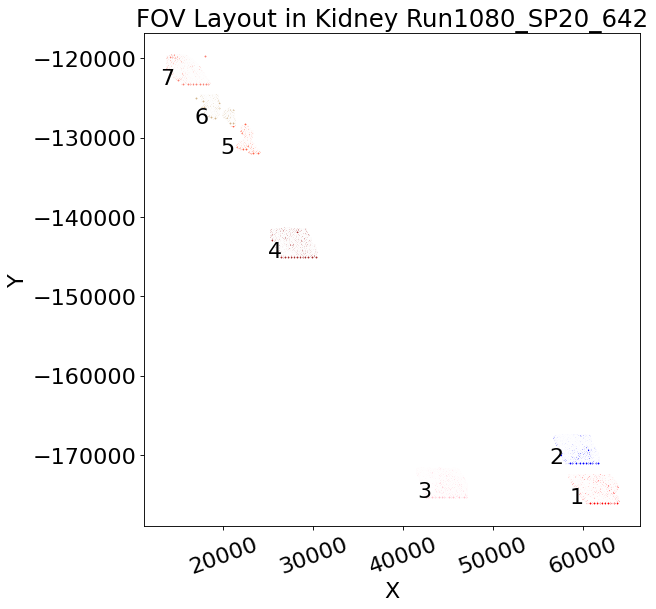

In [15]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8), dpi=80)

np.random.seed(20)
color = ["red", "blue", "pink", "brown", "tomato", "tan", "salmon", "gray", "olive", \
         "cyan", "purple", "green", "orange", "bisque", "darkorange", "navy", "seagreen", \
         "gold", "teal", "peru", "lightpink", "teal", "plum", "violet", "lavender", "khaki",\
        "red", "blue", "pink", "brown", "tomato", "tan", "salmon", "gray", "olive",\
        "cyan", "purple", "green", "orange", "bisque", "darkorange", "navy", "seagreen",\
        "gold", "teal", "peru", "lightpink", "teal", "plum", "violet", "lavender", "khaki",\
         "red", "blue", "pink", "brown", "tomato", "tan", "salmon", "gray", "olive", \
         "cyan", "purple", "green", "orange", "bisque", "darkorange", "navy", "seagreen", \
         "gold", "teal", "peru", "lightpink", "teal", "plum", "violet", "lavender", "khaki"
        ]
for i in range(len(fov_ids_lst)):
    fov_id = fov_ids_lst[i]
    X = cell_boundary[(cell_boundary['fov']==fov_id)]["CenterX_global_px"].tolist()
    Y = cell_boundary[(cell_boundary['fov']==fov_id)]["CenterY_global_px"].tolist()

    plt.scatter(X, Y, s=30, label = fov_id, c = color[i], marker='.', alpha = None, edgecolors= 'white')
#     plt.legend()

X = fov_position["x_global_px"].tolist()
Y = fov_position["y_global_px"].tolist()

X_plus = [i+ 5472 for i in X]
Y_plus = [i+3648 for i in Y]

annotations = (fov_position["fov"]).tolist()


plt.xticks(fontsize=20, rotation=20)
plt.yticks(fontsize=20)
plt.xlabel('X', fontsize=20)
plt.ylabel('Y', fontsize=20)
plt.title("FOV Layout in Kidney Run1080_SP20_642",fontsize=22)
for i, label in enumerate(annotations):
    plt.annotate(label, (X[i], Y[i]), size=20)

plt.show()


In [16]:
# for fov_id in fov_ids_lst:
#     print("fov_id:", fov_id, cell_boundary[(cell_boundary['fov']==fov_id)].shape)

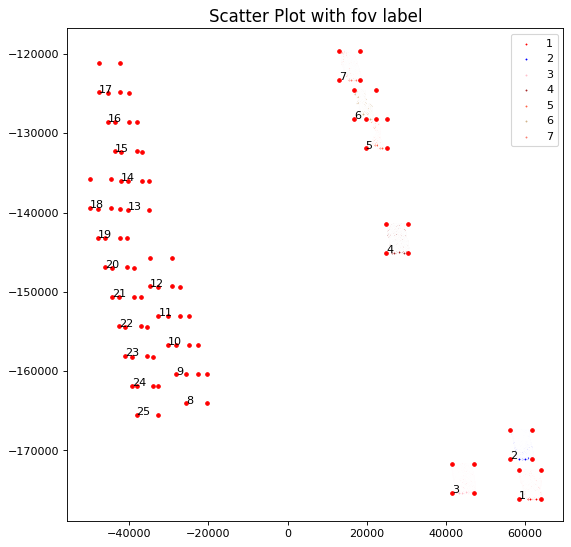

In [17]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8), dpi=80)

np.random.seed(20)
color = ["red", "blue", "pink", "brown", "tomato", "tan", "salmon", "gray", "olive", "cyan", "purple", "green", "orange", "bisque", "darkorange", "navy", "seagreen", "gold", "teal"]
for i in range(len(fov_ids_lst)):
    fov_id = fov_ids_lst[i]
    X = cell_boundary[(cell_boundary['fov']==fov_id)]["CenterX_global_px"].tolist()
    Y = cell_boundary[(cell_boundary['fov']==fov_id)]["CenterY_global_px"].tolist()

    plt.scatter(X, Y, s=30, label = fov_id, c = color[i], marker='.', alpha = None, edgecolors= 'white')
    plt.legend()

X = fov_position["x_global_px"].tolist()
Y = fov_position["y_global_px"].tolist()

X_plus = [i+ 5472 for i in X]
Y_plus = [i+ 3648 for i in Y]

annotations = (fov_position["fov"]).tolist()

plt.scatter(X,Y,s=10,color="red")
plt.scatter(X_plus, Y_plus,s=10,color="red")
plt.scatter(X_plus, Y,s=10,color="red")
plt.scatter(X, Y_plus,s=10,color="red")


plt.title("Scatter Plot with fov label",fontsize=15)
for i, label in enumerate(annotations):
    plt.annotate(label, (X[i], Y[i]))


plt.show()


In [18]:
data_final_result = pd.DataFrame(columns = [ 'fov', 'spot_id', 'cell_ID'])

fov_ids_lst = cell_boundary['fov'].unique()
print("fov_ids_lst:", fov_ids_lst)

for fov_id in tqdm(fov_ids_lst):
    # print("fov_id:", fov_id)
    cell_boundary_fov =  cell_boundary[(cell_boundary['fov']==fov_id)]
    # print("cell_boundary_fov_without_spot_id:", cell_boundary_fov.shape)
    data_final_result = get_spot_fov_cellId_mapping(data_final_result, cell_boundary_fov)



fov_ids_lst: [1 2 3 4 5 6 7]


100%|██████████| 7/7 [00:15<00:00,  2.21s/it]


In [19]:
data_final_result

,fov,spot_id,cell_ID
0,1.0,12.0,1.0
1,1.0,4.0,2.0
2,1.0,8.0,3.0
3,1.0,8.0,4.0
4,1.0,8.0,5.0
...,...,...,...
14312,7.0,9.0,2134.0
14313,7.0,13.0,2135.0
14314,7.0,17.0,2136.0
14315,7.0,17.0,2137.0


In [20]:
data_final_result_sample = data_final_result[(data_final_result['fov']==1)]
data_final_result_sample

,fov,spot_id,cell_ID
0,1.0,12.0,1.0
1,1.0,4.0,2.0
2,1.0,8.0,3.0
3,1.0,8.0,4.0
4,1.0,8.0,5.0
...,...,...,...
2793,1.0,9.0,2794.0
2794,1.0,13.0,2795.0
2795,1.0,13.0,2796.0
2796,1.0,9.0,2797.0


In [21]:
# data_final_result.to_csv('./Run1080_SP20_642/new/spot_fov_cellId_mapping.csv')

## 2. spot_gene_expression.csv

In [22]:
# data_final_result = pd.read_csv('./Run1080_SP20_642/new/spot_fov_cellId_mapping.csv')
data_final_result

,fov,spot_id,cell_ID
0,1.0,12.0,1.0
1,1.0,4.0,2.0
2,1.0,8.0,3.0
3,1.0,8.0,4.0
4,1.0,8.0,5.0
...,...,...,...
14312,7.0,9.0,2134.0
14313,7.0,13.0,2135.0
14314,7.0,17.0,2136.0
14315,7.0,17.0,2137.0


In [23]:
gene_expression

,fov,cell_ID,AATK,ABL1,ABL2,ACE,ACE2,ACKR1,ACKR3,ACKR4,...,NegPrb13,NegPrb14,NegPrb15,NegPrb16,NegPrb18,NegPrb19,NegPrb20,NegPrb21,NegPrb22,NegPrb23
0,1,0,22,24,18,15,48,12,7,24,...,10,20,15,17,21,21,13,11,13,28
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,2,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,3,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1,4,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14319,7,2134,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14320,7,2135,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14321,7,2136,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14322,7,2137,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
names = ['fov'] + ['spot-id=' + str(i) for i in range(1, 21)]
fov_dic = {}
for i in names:
    fov_dic[i] = 0



In [25]:
fov_spot_cells_stats = pd.DataFrame(columns = names)
fov_ids_lst = cell_boundary['fov'].unique()
spot_id_lst = list(range(1, 21))

for fov_id in fov_ids_lst:
    fov_data = data_final_result[(data_final_result['fov']==fov_id)]
    
    fov_dic_sample = fov_dic
    fov_dic_sample["fov"] = fov_id
    
    for i in spot_id_lst:
        spot_id_data = fov_data[(fov_data['spot_id']==i)]
        spot_id_num = "spot-id=" + str(i)
        fov_dic_sample[spot_id_num] = spot_id_data.shape[0]
    fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)


In [26]:
# fov_spot_cells_stats.to_csv('./Run1080_SP20_642/new/fov_new_spot_cell_stats.csv')
fov_spot_cells_stats

,fov,spot-id=1,spot-id=2,spot-id=3,spot-id=4,spot-id=5,spot-id=6,spot-id=7,spot-id=8,spot-id=9,...,spot-id=11,spot-id=12,spot-id=13,spot-id=14,spot-id=15,spot-id=16,spot-id=17,spot-id=18,spot-id=19,spot-id=20
0,1,0,6,86,157,91,164,219,193,195,...,238,198,174,187,203,197,97,61,107,43
1,2,0,0,29,60,86,148,177,202,180,...,218,212,193,202,243,196,195,121,79,18
2,3,33,53,124,174,171,209,208,180,225,...,212,186,239,196,198,214,235,189,136,52
3,4,1,19,40,49,115,123,90,86,147,...,155,119,115,115,113,94,86,83,49,1
4,5,0,0,0,1,25,24,0,20,69,...,123,58,113,24,22,0,0,0,0,0
5,6,0,0,2,32,16,141,111,170,8,...,73,36,100,71,2,0,3,0,0,0
6,7,0,0,35,20,26,163,165,137,100,...,211,166,201,194,199,55,195,73,3,1


In [27]:
data_final_result[(data_final_result['fov']==fov_id)]

,fov,spot_id,cell_ID
12179,7.0,8.0,1.0
12180,7.0,8.0,2.0
12181,7.0,8.0,3.0
12182,7.0,8.0,4.0
12183,7.0,12.0,5.0
...,...,...,...
14312,7.0,9.0,2134.0
14313,7.0,13.0,2135.0
14314,7.0,17.0,2136.0
14315,7.0,17.0,2137.0


In [28]:
def get_spot_gene_expression(spot_cell_mapping, fov_expression, spot_id):
    genes_lst = (fov_expression.columns)[2:].tolist()
    
#     gene_count_dic = {}
#     for gene_name in genes_lst:
#         gene_count_dic[gene_name] = 0
    
    cell_id_lst = spot_cell_mapping[(spot_cell_mapping['spot_id']==spot_id)]["cell_ID"].tolist()
    
    cell_gene_expression_total = len(genes_lst)*[0]
    for cell_id in cell_id_lst:
        cell_gene_expression = fov_expression[(fov_expression['cell_ID'] == cell_id)]
        cell_gene_expression = cell_gene_expression.values.tolist()[0][2:]
        cell_gene_expression_total = np.sum([cell_gene_expression_total, cell_gene_expression], axis=0).tolist()
    
    return cell_gene_expression_total
    
    

In [29]:
fov_ids_lst = cell_boundary['fov'].unique()
spot_id_lst = list(range(1, 21))
spot_gene_expression = ["fov", "spot_id"]
genes_name_lst = (gene_expression.columns)[2:].tolist()
spot_gene_expression = spot_gene_expression + genes_name_lst
spot_gene_expression = pd.DataFrame(columns = spot_gene_expression)

for fov_id in fov_ids_lst:
    fov_data = data_final_result[(data_final_result['fov']==fov_id)]
    print("fov_id:", fov_id)
#     print("fov_data", fov_data)
    fov_gene_expression = gene_expression[(gene_expression['fov'] == fov_id)]
#     print("fov_gene_expression:", fov_gene_expression)
    
    for spot_id in spot_id_lst:
        to_append = [fov_id, spot_id]
        spot_gene_express = get_spot_gene_expression(fov_data, fov_gene_expression, spot_id)
        to_append = to_append + spot_gene_express
        a_series = pd.Series(to_append, index = spot_gene_expression.columns)
        spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
       
#     print(spot_gene_express, len(spot_gene_express))
    


fov_id: 1
fov_id: 2
fov_id: 3
fov_id: 4
fov_id: 5
fov_id: 6
fov_id: 7


In [30]:
spot_gene_expression

,fov,spot_id,AATK,ABL1,ABL2,ACE,ACE2,ACKR1,ACKR3,ACKR4,...,NegPrb13,NegPrb14,NegPrb15,NegPrb16,NegPrb18,NegPrb19,NegPrb20,NegPrb21,NegPrb22,NegPrb23
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2,0,0,0,0,2,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,1,3,5,6,4,6,17,2,2,5,...,1,7,3,5,5,0,9,7,4,5
3,1,4,7,19,9,5,15,3,6,7,...,2,1,5,3,2,4,9,6,9,10
4,1,5,3,6,3,5,1,0,1,1,...,1,3,2,0,3,2,6,2,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,7,16,6,6,7,5,10,5,6,4,...,2,1,4,4,3,1,3,3,1,0
136,7,17,4,13,22,12,47,3,12,18,...,6,8,8,4,8,19,13,4,10,17
137,7,18,6,6,7,7,29,6,9,5,...,3,2,0,2,7,1,6,7,1,5
138,7,19,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,2,1


In [31]:
# spot_gene_expression.to_csv('./Run1080_SP20_642/new/spot_gene_expression.csv')

## before 3

In [32]:
SAMPLE_ID = 7
CosMx_cell_type = pd.read_csv('./annot.csv')
sample_cell_count_dic = {}
sample_fov_count_dic = {}
for i in range(1, 11):
    sample_cell_count_dic[i] = 0
    sample_fov_count_dic[i] = []
print("cell:", sample_cell_count_dic)
print("fov:", sample_fov_count_dic)


sample_7_index_list = []
cell_id_lst = CosMx_cell_type["cell_ID"].tolist()
print("len of cell_id_lst:", len(cell_id_lst))
fov_lst = []
index = 0
for i in range(len(cell_id_lst)):
    sample_id = int(cell_id_lst[i].split("_")[1])
    fov_id = int(cell_id_lst[i].split("_")[2])
    cell_id = int(cell_id_lst[i].split("_")[3])

    if sample_id == SAMPLE_ID:
        sample_7_index_list.append(index)
        
    sample_cell_count_dic[sample_id] =  sample_cell_count_dic[sample_id] + 1
    
    if fov_id not in sample_fov_count_dic[sample_id]:
        sample_fov_count_dic[sample_id].append(fov_id)
    
    if sample_id == SAMPLE_ID:
        if fov_id not in fov_lst:
            fov_lst.append(fov_id)
    index += 1

print(sample_cell_count_dic)
print(sample_fov_count_dic)
print(fov_lst)
print(len(sample_7_index_list))

len(sample_7_index_list)

cell: {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0}
fov: {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: []}
len of cell_id_lst: 296838
{1: 28880, 2: 19616, 3: 28000, 4: 13455, 5: 61073, 6: 16474, 7: 12404, 8: 32534, 9: 34902, 10: 49500}
{1: [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25], 2: [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24], 3: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 4: [18, 19, 20, 21, 22, 23, 24, 25], 5: [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25], 6: [1, 2, 3, 4, 5, 6, 7, 8], 7: [1, 2, 3, 4, 5, 6, 7], 8: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17], 9: [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24], 10: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]}
[1, 2, 3, 4, 5, 6, 7]
12404


12404

## 3. Ground Truth

In [33]:
# CosMx_cell_type = pd.read_csv('./annot.csv')
CosMx_cell_type

,Unnamed: 0,cell_ID,fov,Area,AspectRatio,Width,Height,Mean.CD298,Max.CD298,Mean.PanCK,...,totalcounts,log10totalcounts,background,remove_flagged_cells,IFcolor,nb_clus,leiden_clus,negmean,class,cell_type
0,1,c_1_13_1,13,4002,1.60,88,55,11986,28069,5650,...,20,1.301030,0.006710,False,#4A5202FF,NotDet,5,0.05,III,Podocyte
1,2,c_1_13_2,13,5472,1.90,116,61,15688,33560,194,...,632,2.800717,0.212033,False,#050300FF,a,7,0.50,III,Proliferating.Proximal.Tubule
2,3,c_1_13_3,13,4925,1.42,95,67,15469,44395,254,...,271,2.432969,0.090919,False,#0F0400FF,a,4,0.20,III,Distinct.proximal.tubule.2
3,4,c_1_13_4,13,8394,1.33,124,93,14543,63023,368,...,555,2.744293,0.186200,False,#050504FF,a,7,0.35,III,Distinct.proximal.tubule.1
4,5,c_1_13_5,13,2147,1.66,68,41,10302,30099,3765,...,163,2.212188,0.054686,False,#023700FF,T CD4 memory,7,0.15,III,Pelvic.epithelium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296833,296834,c_10_13_3887,13,1292,2.76,69,25,16245,58372,60969,...,67,1.826075,0.022478,False,#B3FFC9FF,d,2,0.00,III,Connecting.tubule
296834,296835,c_10_13_3888,13,2381,3.00,96,32,15011,32146,545,...,34,1.531479,0.011407,False,#090816FF,b,5,0.00,III,Fibroblast
296835,296836,c_10_13_3889,13,2543,2.27,84,37,16767,58501,31444,...,75,1.875061,0.025162,False,#85FFFFFF,d,2,0.00,III,Connecting.tubule
296836,296837,c_10_13_3890,13,1630,1.91,65,34,18983,30878,1379,...,25,1.397940,0.008387,False,#4E146EFF,b,5,0.00,III,Myofibroblast


In [34]:
# set(CosMx_cell_type["fov"].tolist())

In [35]:
# CosMx_cell_type.columns.values[0] = "sample_id"
# CosMx_cell_type
CosMx_cell_type_sample_7 = CosMx_cell_type.iloc[sample_7_index_list]
CosMx_cell_type_sample_7

,Unnamed: 0,cell_ID,fov,Area,AspectRatio,Width,Height,Mean.CD298,Max.CD298,Mean.PanCK,...,totalcounts,log10totalcounts,background,remove_flagged_cells,IFcolor,nb_clus,leiden_clus,negmean,class,cell_type
167498,167499,c_7_1_2,1,3678,1.09,70,64,3687,11749,261,...,200,2.301030,0.067099,False,#0E045AFF,b,8,0.05,IV+V,Distinct.proximal.tubule.1
167499,167500,c_7_1_3,1,7194,1.24,112,90,5267,20111,218,...,352,2.546543,0.118095,False,#30035CFF,b,8,0.05,IV+V,Distinct.proximal.tubule.2
167500,167501,c_7_1_4,1,5666,1.23,92,75,5519,17017,276,...,292,2.465383,0.097965,False,#2E0464FF,e,3,0.00,IV+V,Distinct.proximal.tubule.2
167501,167502,c_7_1_5,1,3149,0.83,58,70,3052,7255,1577,...,102,2.008600,0.034221,False,#671737FF,f,2,0.00,IV+V,Epithelial.progenitor.cell
167502,167503,c_7_1_6,1,4633,1.00,78,78,2873,17741,282,...,309,2.489958,0.103668,False,#320443FF,b,6,0.00,IV+V,Fibroblast
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179897,179898,c_7_7_2133,7,2507,2.34,89,38,2,803,1861,...,84,1.924279,0.028182,False,#101B25FF,e,1,0.15,IV+V,Proximal.tubule
179898,179899,c_7_7_2134,7,2547,2.08,81,39,8,1047,792,...,47,1.672098,0.015768,False,#390C49FF,e,1,0.15,IV+V,Proximal.tubule
179899,179900,c_7_7_2135,7,1506,1.26,49,39,2666,52098,1220,...,74,1.869232,0.024827,False,#001206FF,e,5,0.00,IV+V,Proliferating.Proximal.Tubule
179900,179901,c_7_7_2136,7,2227,1.72,67,39,2112,11114,53,...,68,1.832509,0.022814,False,#020100FF,b,7,0.05,IV+V,Fibroblast


In [36]:
CosMx_cell_type_sample_7.reset_index(drop=True, inplace=True)
CosMx_cell_type_sample_7

,Unnamed: 0,cell_ID,fov,Area,AspectRatio,Width,Height,Mean.CD298,Max.CD298,Mean.PanCK,...,totalcounts,log10totalcounts,background,remove_flagged_cells,IFcolor,nb_clus,leiden_clus,negmean,class,cell_type
0,167499,c_7_1_2,1,3678,1.09,70,64,3687,11749,261,...,200,2.301030,0.067099,False,#0E045AFF,b,8,0.05,IV+V,Distinct.proximal.tubule.1
1,167500,c_7_1_3,1,7194,1.24,112,90,5267,20111,218,...,352,2.546543,0.118095,False,#30035CFF,b,8,0.05,IV+V,Distinct.proximal.tubule.2
2,167501,c_7_1_4,1,5666,1.23,92,75,5519,17017,276,...,292,2.465383,0.097965,False,#2E0464FF,e,3,0.00,IV+V,Distinct.proximal.tubule.2
3,167502,c_7_1_5,1,3149,0.83,58,70,3052,7255,1577,...,102,2.008600,0.034221,False,#671737FF,f,2,0.00,IV+V,Epithelial.progenitor.cell
4,167503,c_7_1_6,1,4633,1.00,78,78,2873,17741,282,...,309,2.489958,0.103668,False,#320443FF,b,6,0.00,IV+V,Fibroblast
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12399,179898,c_7_7_2133,7,2507,2.34,89,38,2,803,1861,...,84,1.924279,0.028182,False,#101B25FF,e,1,0.15,IV+V,Proximal.tubule
12400,179899,c_7_7_2134,7,2547,2.08,81,39,8,1047,792,...,47,1.672098,0.015768,False,#390C49FF,e,1,0.15,IV+V,Proximal.tubule
12401,179900,c_7_7_2135,7,1506,1.26,49,39,2666,52098,1220,...,74,1.869232,0.024827,False,#001206FF,e,5,0.00,IV+V,Proliferating.Proximal.Tubule
12402,179901,c_7_7_2136,7,2227,1.72,67,39,2112,11114,53,...,68,1.832509,0.022814,False,#020100FF,b,7,0.05,IV+V,Fibroblast


In [37]:

for i in CosMx_cell_type_sample_7.index:
#     print(i)
    
#     sample_id = int(CosMx_cell_type.iloc[i]["cell_ID"].split("_")[1])
#     fov_id = int(CosMx_cell_type.iloc[i]["cell_ID"].split("_")[2])
#     cell_id = int(CosMx_cell_type.iloc[i]["cell_ID"].split("_")[3])

#     CosMx_cell_type_sample_8.at[i,'sample_id']= int(CosMx_cell_type_sample_8.iloc[i]["cell_ID"].split("_")[1])
    CosMx_cell_type_sample_7.at[i,'cell_ID']= int(CosMx_cell_type_sample_7.iloc[i]["cell_ID"].split("_")[3])

CosMx_cell_type_sample_7


,Unnamed: 0,cell_ID,fov,Area,AspectRatio,Width,Height,Mean.CD298,Max.CD298,Mean.PanCK,...,totalcounts,log10totalcounts,background,remove_flagged_cells,IFcolor,nb_clus,leiden_clus,negmean,class,cell_type
0,167499,2,1,3678,1.09,70,64,3687,11749,261,...,200,2.301030,0.067099,False,#0E045AFF,b,8,0.05,IV+V,Distinct.proximal.tubule.1
1,167500,3,1,7194,1.24,112,90,5267,20111,218,...,352,2.546543,0.118095,False,#30035CFF,b,8,0.05,IV+V,Distinct.proximal.tubule.2
2,167501,4,1,5666,1.23,92,75,5519,17017,276,...,292,2.465383,0.097965,False,#2E0464FF,e,3,0.00,IV+V,Distinct.proximal.tubule.2
3,167502,5,1,3149,0.83,58,70,3052,7255,1577,...,102,2.008600,0.034221,False,#671737FF,f,2,0.00,IV+V,Epithelial.progenitor.cell
4,167503,6,1,4633,1.00,78,78,2873,17741,282,...,309,2.489958,0.103668,False,#320443FF,b,6,0.00,IV+V,Fibroblast
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12399,179898,2133,7,2507,2.34,89,38,2,803,1861,...,84,1.924279,0.028182,False,#101B25FF,e,1,0.15,IV+V,Proximal.tubule
12400,179899,2134,7,2547,2.08,81,39,8,1047,792,...,47,1.672098,0.015768,False,#390C49FF,e,1,0.15,IV+V,Proximal.tubule
12401,179900,2135,7,1506,1.26,49,39,2666,52098,1220,...,74,1.869232,0.024827,False,#001206FF,e,5,0.00,IV+V,Proliferating.Proximal.Tubule
12402,179901,2136,7,2227,1.72,67,39,2112,11114,53,...,68,1.832509,0.022814,False,#020100FF,b,7,0.05,IV+V,Fibroblast


In [38]:
sample_7_dic = {}
for key in CosMx_cell_type_sample_7["cell_type"].tolist():
    if key not in sample_7_dic:
        sample_7_dic[key] = 1
    else:
        sample_7_dic[key] = sample_7_dic[key] + 1

sample_7_dic


{'Distinct.proximal.tubule.1': 1191,
 'Distinct.proximal.tubule.2': 777,
 'Epithelial.progenitor.cell': 2687,
 'Fibroblast': 727,
 'Ascending.vasa.recta.endothelium': 1216,
 'Proximal.tubule': 1460,
 'Myofibroblast': 719,
 'Connecting.tubule': 211,
 'Peritubular.capillary.endothelium.1': 256,
 'Proliferating.Proximal.Tubule': 485,
 'MNP.b.non.classical.monocyte.derived': 44,
 'Podocyte': 116,
 'Descending.vasa.recta.endothelium': 289,
 'T CD4 memory': 16,
 'Glomerular.endothelium': 103,
 'MNP.c.dendritic.cell': 349,
 'macrophage': 457,
 'Principal.cell': 383,
 'MNP.a.classical.monocyte.derived': 42,
 'Peritubular.capillary.endothelium.2': 74,
 'Type.A.intercalated.cell': 58,
 'Pelvic.epithelium': 68,
 'Thick.ascending.limb.of.Loop.of.Henle': 202,
 'T CD8 memory': 32,
 'Type.B.intercalated.cell': 4,
 'plasmablast': 267,
 'B-cell': 120,
 'mDC': 8,
 'Transitional.urothelium': 3,
 'NK': 7,
 'Treg': 13,
 'pDC': 12,
 'T CD4 naive': 3,
 'Indistinct.intercalated.cell': 1,
 'T CD8 naive': 4}

In [39]:
CosMx_cell_type_sample_7_fov_1 = CosMx_cell_type_sample_7[(CosMx_cell_type_sample_7['fov']==8)]
CosMx_cell_type_sample_7_fov_1

,Unnamed: 0,cell_ID,fov,Area,AspectRatio,Width,Height,Mean.CD298,Max.CD298,Mean.PanCK,...,totalcounts,log10totalcounts,background,remove_flagged_cells,IFcolor,nb_clus,leiden_clus,negmean,class,cell_type


In [40]:
cell_type_lst = set(CosMx_cell_type_sample_7['cell_type'].tolist())
print(len(cell_type_lst))
cell_type_lst

35


{'Ascending.vasa.recta.endothelium',
 'B-cell',
 'Connecting.tubule',
 'Descending.vasa.recta.endothelium',
 'Distinct.proximal.tubule.1',
 'Distinct.proximal.tubule.2',
 'Epithelial.progenitor.cell',
 'Fibroblast',
 'Glomerular.endothelium',
 'Indistinct.intercalated.cell',
 'MNP.a.classical.monocyte.derived',
 'MNP.b.non.classical.monocyte.derived',
 'MNP.c.dendritic.cell',
 'Myofibroblast',
 'NK',
 'Pelvic.epithelium',
 'Peritubular.capillary.endothelium.1',
 'Peritubular.capillary.endothelium.2',
 'Podocyte',
 'Principal.cell',
 'Proliferating.Proximal.Tubule',
 'Proximal.tubule',
 'T CD4 memory',
 'T CD4 naive',
 'T CD8 memory',
 'T CD8 naive',
 'Thick.ascending.limb.of.Loop.of.Henle',
 'Transitional.urothelium',
 'Treg',
 'Type.A.intercalated.cell',
 'Type.B.intercalated.cell',
 'mDC',
 'macrophage',
 'pDC',
 'plasmablast'}

In [41]:
spot_celld_mapping = pd.read_csv('./Run1080_SP20_642/new/spot_fov_cellId_mapping.csv')
spot_celld_mapping

,Unnamed: 0,fov,spot_id,cell_ID
0,0,1.0,100.0,1.0
1,1,1.0,40.0,2.0
2,2,1.0,50.0,3.0
3,3,1.0,60.0,4.0
4,4,1.0,80.0,5.0
...,...,...,...,...
14312,14312,7.0,91.0,2134.0
14313,14313,7.0,141.0,2135.0
14314,14314,7.0,161.0,2136.0
14315,14315,7.0,181.0,2137.0


In [42]:
CosMx_cell_type_sample_7


,Unnamed: 0,cell_ID,fov,Area,AspectRatio,Width,Height,Mean.CD298,Max.CD298,Mean.PanCK,...,totalcounts,log10totalcounts,background,remove_flagged_cells,IFcolor,nb_clus,leiden_clus,negmean,class,cell_type
0,167499,2,1,3678,1.09,70,64,3687,11749,261,...,200,2.301030,0.067099,False,#0E045AFF,b,8,0.05,IV+V,Distinct.proximal.tubule.1
1,167500,3,1,7194,1.24,112,90,5267,20111,218,...,352,2.546543,0.118095,False,#30035CFF,b,8,0.05,IV+V,Distinct.proximal.tubule.2
2,167501,4,1,5666,1.23,92,75,5519,17017,276,...,292,2.465383,0.097965,False,#2E0464FF,e,3,0.00,IV+V,Distinct.proximal.tubule.2
3,167502,5,1,3149,0.83,58,70,3052,7255,1577,...,102,2.008600,0.034221,False,#671737FF,f,2,0.00,IV+V,Epithelial.progenitor.cell
4,167503,6,1,4633,1.00,78,78,2873,17741,282,...,309,2.489958,0.103668,False,#320443FF,b,6,0.00,IV+V,Fibroblast
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12399,179898,2133,7,2507,2.34,89,38,2,803,1861,...,84,1.924279,0.028182,False,#101B25FF,e,1,0.15,IV+V,Proximal.tubule
12400,179899,2134,7,2547,2.08,81,39,8,1047,792,...,47,1.672098,0.015768,False,#390C49FF,e,1,0.15,IV+V,Proximal.tubule
12401,179900,2135,7,1506,1.26,49,39,2666,52098,1220,...,74,1.869232,0.024827,False,#001206FF,e,5,0.00,IV+V,Proliferating.Proximal.Tubule
12402,179901,2136,7,2227,1.72,67,39,2112,11114,53,...,68,1.832509,0.022814,False,#020100FF,b,7,0.05,IV+V,Fibroblast


In [43]:
cell_id_lst = CosMx_cell_type_sample_7["cell_ID"].tolist()

In [44]:
def get_spot_cell_type_dic(one_spot_cell_lst, CosMx_cell_type, cell_type_dic):
    existig_cell_ids_with_celltype = CosMx_cell_type['cell_ID'].unique()
    
#     import ipdb
#     ipdb.set_trace()

    for cell_id in one_spot_cell_lst:
        
        if cell_id in existig_cell_ids_with_celltype:
            one_cell_sample = CosMx_cell_type[(CosMx_cell_type['cell_ID']==cell_id)]
            cell_type = one_cell_sample["cell_type"].values[0]
            cell_type_dic[cell_type] = cell_type_dic[cell_type] + 1
        # else:
        #     print("cell id not found in groud truth!!!")
        
    return cell_type_dic



In [45]:
# spot_celld_mapping = pd.read_csv('./Run1080_SP20_642/new/spot_fov_cellId_mapping.csv')
spot_celld_mapping

,Unnamed: 0,fov,spot_id,cell_ID
0,0,1.0,100.0,1.0
1,1,1.0,40.0,2.0
2,2,1.0,50.0,3.0
3,3,1.0,60.0,4.0
4,4,1.0,80.0,5.0
...,...,...,...,...
14312,14312,7.0,91.0,2134.0
14313,14313,7.0,141.0,2135.0
14314,14314,7.0,161.0,2136.0
14315,14315,7.0,181.0,2137.0


In [46]:
fov_ids_lst = spot_celld_mapping['fov'].unique()
print(fov_ids_lst)
fov_data = spot_celld_mapping[(spot_celld_mapping['fov']==1)]
print("fov:", fov_data)
spot_id_data = fov_data[(fov_data['spot_id']==1)]
print("spot:", spot_id_data)

[1. 2. 3. 4. 5. 6. 7.]
fov:       Unnamed: 0  fov  spot_id  cell_ID
0              0  1.0    100.0      1.0
1              1  1.0     40.0      2.0
2              2  1.0     50.0      3.0
3              3  1.0     60.0      4.0
4              4  1.0     80.0      5.0
...          ...  ...      ...      ...
2793        2793  1.0    111.0   2794.0
2794        2794  1.0    141.0   2795.0
2795        2795  1.0    151.0   2796.0
2796        2796  1.0    101.0   2797.0
2797        2797  1.0    151.0   2798.0

[2798 rows x 4 columns]
spot: Empty DataFrame
Columns: [Unnamed: 0, fov, spot_id, cell_ID]
Index: []


In [47]:
column_name_lst = ['fov', 'spot_id'] + sorted(cell_type_lst)
ground_truth_table = pd.DataFrame(columns = column_name_lst)


fov_ids_lst = spot_celld_mapping['fov'].unique()
spot_id_lst = list(range(1, 21))

for fov_id in fov_ids_lst:
    fov_data = spot_celld_mapping[(spot_celld_mapping['fov']==fov_id)]

    for spot_id in spot_id_lst:
        sample_dic = {}
        for i in column_name_lst:
            sample_dic[i] = 0
        
        spot_id_data = fov_data[(fov_data['spot_id']==spot_id)]
        one_spot_cell_lst = (spot_id_data['cell_ID'].unique()) # all cell ids for one specific spot
        
        CosMx_cell_type_sample_fov = CosMx_cell_type_sample_7[(CosMx_cell_type_sample_7['fov']==fov_id)]
        sample_dic = get_spot_cell_type_dic(one_spot_cell_lst, CosMx_cell_type_sample_fov, sample_dic)
        
        sample_dic["fov"] = fov_id
        sample_dic["spot_id"] = spot_id
        ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)







In [48]:
ground_truth_table

,fov,spot_id,Ascending.vasa.recta.endothelium,B-cell,Connecting.tubule,Descending.vasa.recta.endothelium,Distinct.proximal.tubule.1,Distinct.proximal.tubule.2,Epithelial.progenitor.cell,Fibroblast,...,T CD8 naive,Thick.ascending.limb.of.Loop.of.Henle,Transitional.urothelium,Treg,Type.A.intercalated.cell,Type.B.intercalated.cell,mDC,macrophage,pDC,plasmablast
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,7.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
136,7.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
137,7.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
138,7.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
# ground_truth_table.to_csv('./Run1080_SP20_642/new/ground_truth.csv')

## 4. Generate spot x, y coordiates

In [50]:
def get_spot_x_y_range(x_global_px, y_global_px, fov_id, fov_spot_coordinates):
    fov_length = 5472
    fov_width = 3648
    x_l = x_global_px
    y_l = y_global_px
    x_h = x_l + fov_length
    y_h = y_l + fov_width
    
    for i in range(1, 6):  # 5
        for j in range(1, 5):  # 4
            spot_id = (i - 1) * 4 + j
            x = x_l + (5472 / 10.0) * 1 + (5472 / 5.0) * (i - 1)
            y = y_h - (3648 / 8.0) * 1 - (3648 / 4.0) * (j - 1)
            fov_spot_coordinates = fov_spot_coordinates.append(
                {'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y},
                ignore_index=True
            )

    fov_spot_coordinates['x'] = fov_spot_coordinates['x']
    fov_spot_coordinates['y'] = fov_spot_coordinates['y']

    # fov_spot_coordinates['x'] = fov_spot_coordinates['x'] * 0.18 * 1e-4
    # fov_spot_coordinates['y'] = fov_spot_coordinates['y'] * 0.18 * 1e-4

    return fov_spot_coordinates


In [51]:
fov_lst = fov_position['fov'].tolist()[:7]

In [52]:
fov_lst

[1, 2, 3, 4, 5, 6, 7]

In [53]:
fov_spot_coordinates = pd.DataFrame(columns = ['fov', 'spot_id', 'x', 'y'])
for fov_id in fov_lst:
    x_px = fov_position[fov_position['fov']==fov_id]["x_global_px"].values[0]
    y_px = fov_position[fov_position['fov']==fov_id]["y_global_px"].values[0]
    fov_spot_coordinates = get_spot_x_y_range(x_px, y_px, fov_id, fov_spot_coordinates)
fov_spot_coordinates

,fov,spot_id,x,y
0,1.0,1.0,59019.422222,-172902.444444
1,1.0,2.0,59019.422222,-173814.444444
2,1.0,3.0,59019.422222,-174726.444444
3,1.0,4.0,59019.422222,-175638.444444
4,1.0,5.0,60113.822222,-172902.444444
...,...,...,...,...
135,7.0,16.0,16747.066667,-122805.111111
136,7.0,17.0,17841.466667,-120069.111111
137,7.0,18.0,17841.466667,-120981.111111
138,7.0,19.0,17841.466667,-121893.111111


In [54]:
# fov_spot_coordinates.to_csv('./Run1080_SP20_642/new/spot_location.csv')

In [55]:
spot_gene_expression = spot_gene_expression.drop(columns = ["fov", "spot_id"])
ground_truth_table = ground_truth_table.drop(columns = ["fov", "spot_id"])
fov_spot_coordinates = fov_spot_coordinates.drop(columns = ["fov", "spot_id"])




In [56]:
import anndata as ad
st_adata = ad.AnnData(X = spot_gene_expression.values, obs = ground_truth_table, var = pd.DataFrame(index = list(spot_gene_expression.columns)), dtype=int)
st_adata.obsm["spatial"] = fov_spot_coordinates.values

spot_sums = np.sum(st_adata.X, axis=1)
mask = spot_sums > 100
filtered_data = st_adata[mask]


file_path = "/home/luqiaolin/projects/Benchmarking_paper_code/pseudo_spot_generation/cosmx_kidney/Run1080_SP20_642.h5ad"

filtered_data.write_h5ad(file_path)